In [1]:
from pathlib import Path
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.style.use('seaborn-v0_8')
plt.rcParams['legend.framealpha'] = 1  ## disable any default legend frame transparency from the style

---
---
# [1] Analyze Each Carr-Purcell Sequence

In [2]:
def plot_purcell(
    fpath           : Path,
    find_peak_params: dict         = ...,  ## default is {'distance': 100, 'height': 1}
    cols            : tuple[int]   = [3,4],
    curve_fit_guess : tuple[float] = (10, 0.01, 1),
    idx_peaks2skip  : tuple[int]   = [],
    title           : str          = '',
) -> dict[str, float | str]:

    # if title:
    #     print(f'Analyzing {title}...')
    # else:
    #     print(f'Analyzing {fpath.name}...')



    # --------------------------------- load data -------------------------------- #
    df = pd.read_csv(
        fpath,
        usecols = cols,
        header = None,
        names = ['t', 'v'],
    )



    # ------------------------------- crop & scale ------------------------------- #

    # df['t'] *= meta['x_scale']
    # df['v'] *= meta['y_scale']

    # df = df[
    #     (df['t'] > meta['x_bounds'][0]) &
    #     (df['t'] < meta['x_bounds'][1])
    # ]



    # ---------------- convert to 1D numpy arrays for convenience ---------------- #
    dat_t = df['t'].to_numpy()
    dat_v = df['v'].to_numpy()



    # -------------------------------- find peaks -------------------------------- #

    default = {'distance': 50, 'height': 1}

    if find_peak_params is ...:
        find_peak_params = {}

    ## merge default and user-provided parameters, with user-provided taking precedence
    find_peak_params = {
        **default,
        **find_peak_params,
    }



    idx_peaks = find_peaks(
        dat_v,
        **find_peak_params,
    )[0]

    idx_peaks = np.delete(idx_peaks, idx_peaks2skip)

    dat_t_peaks = dat_t[idx_peaks]
    dat_v_peaks = dat_v[idx_peaks]



    # ------------------------------------ fit ----------------------------------- #
    def exp_decay(t, A, B, C):
        return A * np.exp(-t/B) + C

    popt, pcov = curve_fit(
        exp_decay,
        dat_t_peaks,
        dat_v_peaks,
        p0 = curve_fit_guess,
    )
    A_fit, B_fit, C_fit = popt
    # print(f'    - Fit: (A, B, C) = ({A_fit:.3f}, {B_fit:.3e}, {C_fit:.3f})')
    # print(f'    - T_2 = {B_fit * 1e3 :.2f} ms')


    dat_t_fit = np.linspace(
        dat_t_peaks.min(),
        dat_t_peaks.max(),
        1000,
    )
    dat_v_fit = exp_decay(dat_t_fit, A_fit, B_fit, C_fit)



    # ----------------------------------- plot ----------------------------------- #

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(
        dat_t * 1e3,
        dat_v,
        label = 'Raw Data',
        # alpha = 0.5,
        linewidth = 1,
    )

    ax.scatter(
        dat_t_peaks * 1e3,
        dat_v_peaks,
        label = f'Echo Peaks (Total {len(idx_peaks)})',
        color = 'firebrick',
        s = 10,
    )

    ax.plot(
        dat_t_fit * 1e3,
        dat_v_fit,
        # 'k-',
        label = (
            r'Decay Envelope: $A \cdot \exp (-t/B) + C$'
            # f'\n$\\Longrightarrow$A={A_fit:.2f}, B={B_fit:.2e}, C={C_fit:.2f}',
            f'\n$ \\Longrightarrow (A,B,C)=$({A_fit:.2f}, {B_fit:.2e}, {C_fit:.2f})'
        ),
        linestyle = 'dashed',
    )

    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Voltage [V]')
    ax.set_title(title)



    t_max = dat_t_peaks.max()
    t_min = dat_t_peaks.min()
    t_diff = t_max - t_min
    padding = 0.1
    ax.set_xlim(
        (t_min - padding*t_diff) * 1e3,
        (t_max + padding*t_diff) * 1e3,
    )



    legend = ax.legend(
        # loc='lower left',
        frameon=True,
    )
    frame = legend.get_frame()
    frame.set_alpha(None)  ## disable any rcParam alpha override
    frame.set_facecolor((1, 1, 1, 0.1))  ## set frame coloring to white with some transparency
    frame.set_edgecolor('black')

    plt.show()

    return {
        'T2 [ms]': B_fit * 1e3,
        'Num Peaks': len(idx_peaks),
        'Total Time [ms]': t_max - t_min,
    }


--------------------------------------------------------------------------------
Mineral Oil
--------------------------------------------------------------------------------



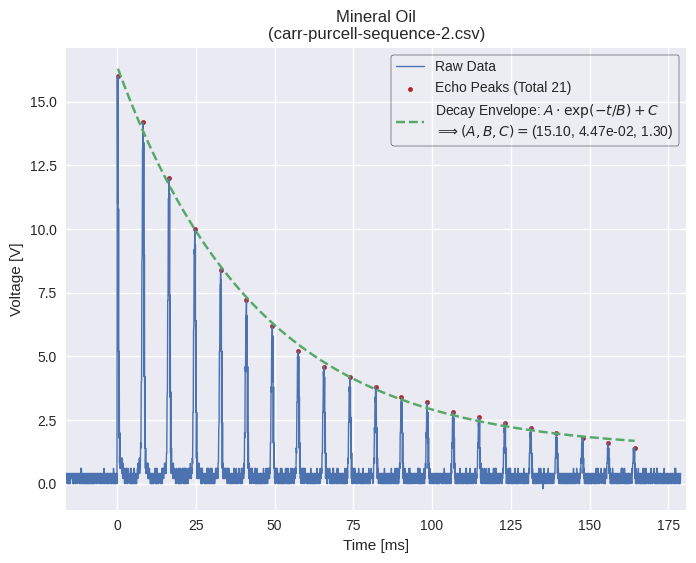

{'Compound': 'Mineral Oil',
 'Num Peaks': 21,
 'T2 [ms]': np.float64(44.69953605619278),
 'Total Time [ms]': np.float64(0.16399999137791002)}



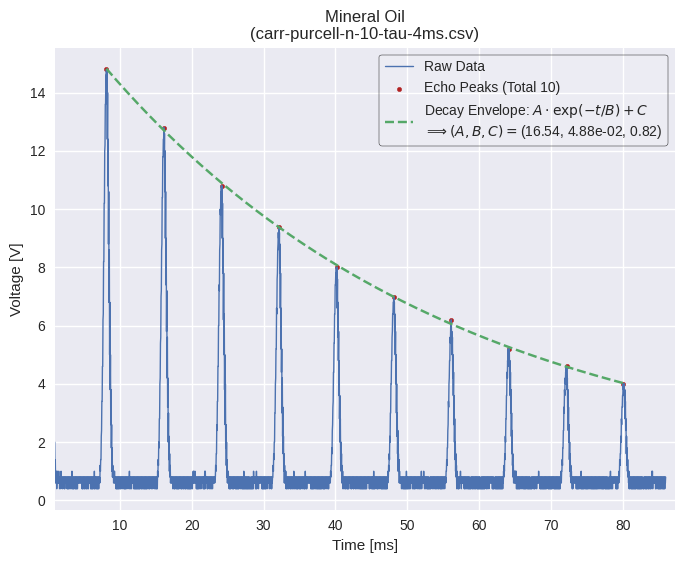

{'Compound': 'Mineral Oil',
 'Num Peaks': 10,
 'T2 [ms]': np.float64(48.79078140994079),
 'Total Time [ms]': np.float64(0.071920000017)}



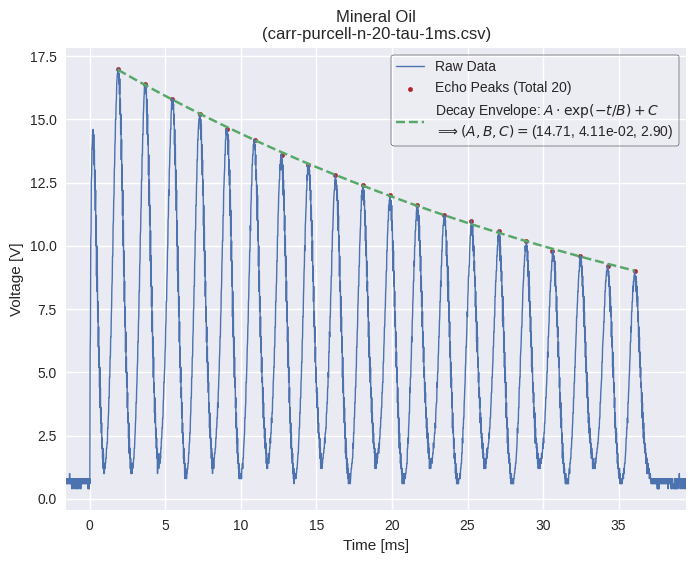

{'Compound': 'Mineral Oil',
 'Num Peaks': 20,
 'T2 [ms]': np.float64(41.09031077788365),
 'Total Time [ms]': np.float64(0.03419999838)}



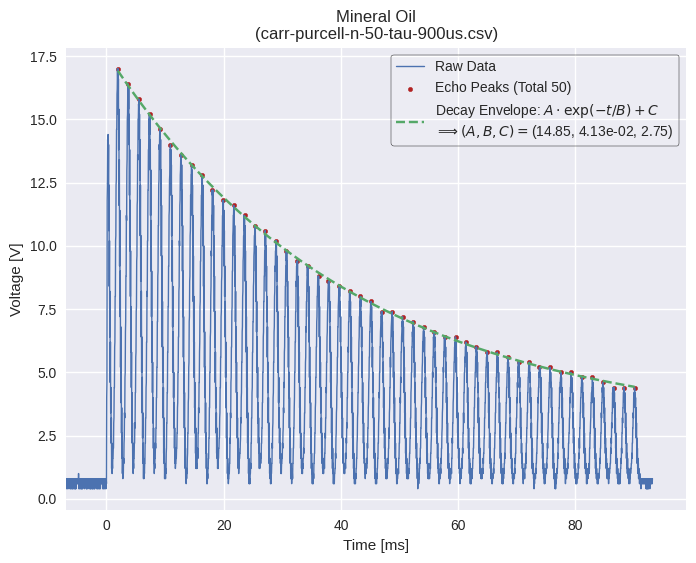

{'Compound': 'Mineral Oil',
 'Num Peaks': 50,
 'T2 [ms]': np.float64(41.33068629310955),
 'Total Time [ms]': np.float64(0.088159995877)}


--------------------------------------------------------------------------------
Glycerol
--------------------------------------------------------------------------------



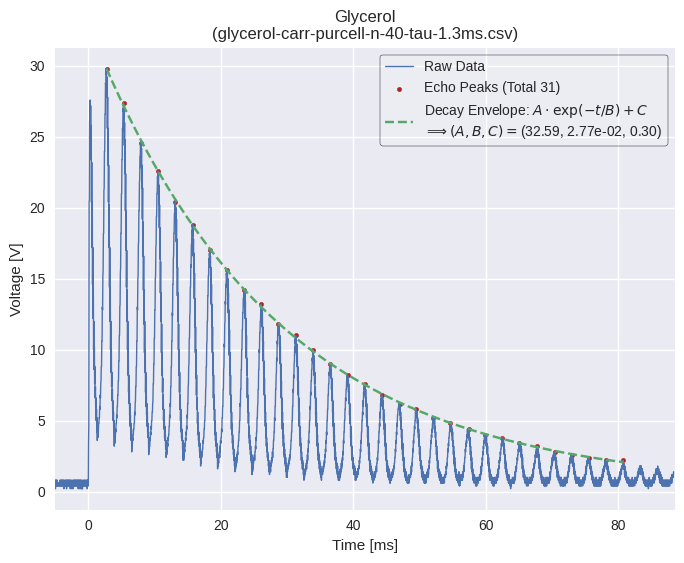

{'Compound': 'Glycerol',
 'Num Peaks': 31,
 'T2 [ms]': np.float64(27.723445053276304),
 'Total Time [ms]': np.float64(0.077999994856)}



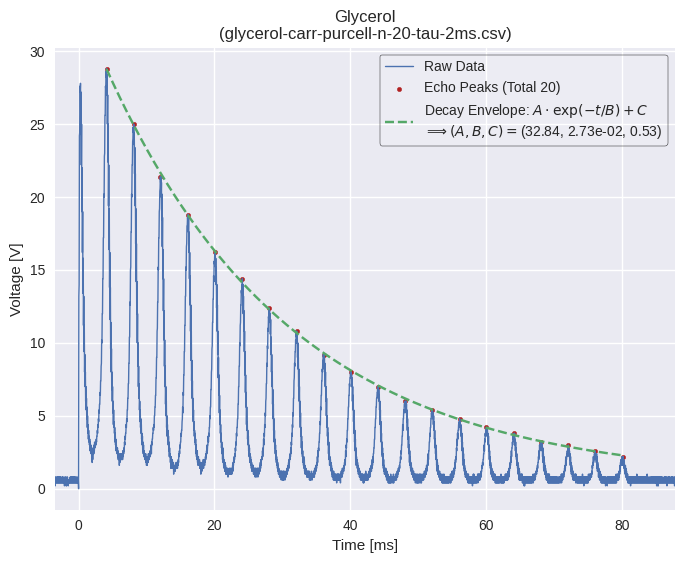

{'Compound': 'Glycerol',
 'Num Peaks': 20,
 'T2 [ms]': np.float64(27.340260415839552),
 'Total Time [ms]': np.float64(0.076079994437)}



In [3]:
# -------------------------------- user input -------------------------------- #

## SPECIFY THIS FOR YOUR OWN COMPUTER!!!
dirpath_repo = Path('/home/lain/root/100_work/110_projects/111_mars/code-repos/redplanet/scrap/nmr/')



# ------------------------------- dataset info ------------------------------- #

dirpath_data = dirpath_repo / 'nmr/nmr_data/purcell/'

metadata = {
    'mineral_oil': {
        'carr-purcell-sequence-2.csv': {
            'cols': [9, 10],
        },
        'carr-purcell-n-10-tau-4ms.csv': {
            'find_peak_params': {
                'height': 3,
            },
            'idx_peaks2skip': [0],
        },
        'carr-purcell-n-20-tau-1ms.csv': {
            'find_peak_params': {
                'height': 3,
            },
            'idx_peaks2skip': [0],
        },
        'carr-purcell-n-50-tau-900us.csv': {
            'find_peak_params': {
                'height': 3,
                'distance': 25,
            },
            'idx_peaks2skip': [0],
        },
    },
    'glycerol': {
        # 'glycerol-carr-purcell-n-50-tau-1ms.csv' : {
        #     'find_peak_params': {
        #         'height': 2,
        #         'distance': 75,
        #     },
        #     'idx_peaks2skip': [0],
        #     'curve_fit_guess': (30, 0.02, 10),
        # },
        'glycerol-carr-purcell-n-40-tau-1.3ms.csv' : {
            'find_peak_params': {
                'height': 1,
            },
            'idx_peaks2skip': [0, -3, -2, -1],
            'curve_fit_guess': (30, 0.02, 10),
        },
        'glycerol-carr-purcell-n-20-tau-2ms.csv' : {
            'find_peak_params': {
                'height': 2,
                'distance': 75,
            },
            'idx_peaks2skip': [0],
            'curve_fit_guess': (30, 0.02, 10),
        },
    },
    # 'deionized_water': {},
}



# --------------------------------- plot all --------------------------------- #

results = []

for dirname_compound in metadata:

    compound_name = dirname_compound.replace('_', ' ').title()

    print()
    print('-' * 80)
    print(compound_name)
    print('-' * 80)
    print()

    for fname, plotting_params in metadata[dirname_compound].items():

        fpath = dirpath_data / dirname_compound / fname
        title = compound_name + f'\n({fname})'

        this_results = plot_purcell(
            fpath,
            **plotting_params,
            title=title,
        )

        this_results['Compound'] = compound_name
        results.append(this_results)

        pprint(this_results)
        print()

---
---
# [2] Overall Results

In [4]:
df_results = pd.DataFrame(results)
df_results

,T2 [ms],Num Peaks,Total Time [ms],Compound
0,44.699536,21,0.16400,Mineral Oil
1,48.790781,10,0.07192,Mineral Oil
2,41.090311,20,0.03420,Mineral Oil
3,41.330686,50,0.08816,Mineral Oil
4,27.723445,31,0.07800,Glycerol
5,27.340260,20,0.07608,Glycerol


In [5]:
df_results.groupby('Compound').agg(
    {
        'T2 [ms]': ['mean', 'std'],
    }
).reset_index()

Compound    T2 [ms]          
                     mean       std
0     Glycerol  27.531853  0.270952
1  Mineral Oil  43.977829  3.606961

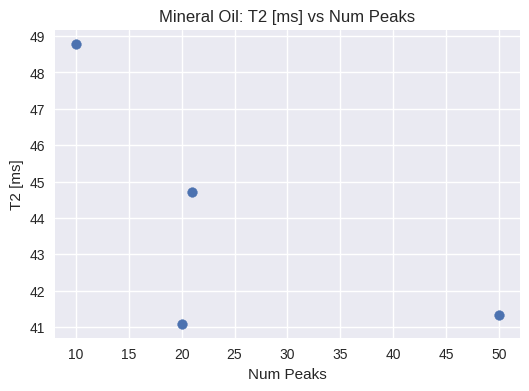

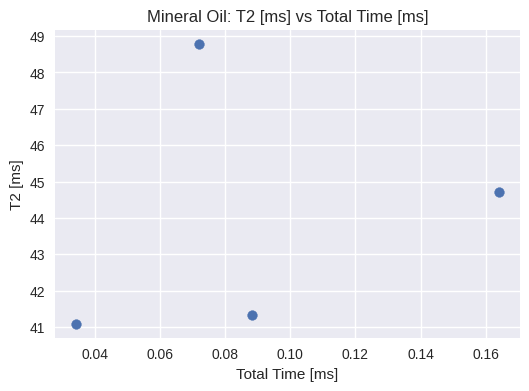

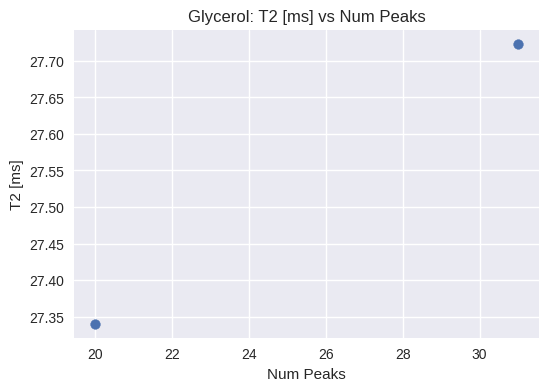

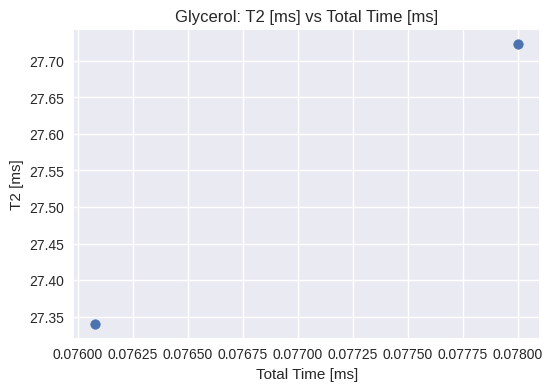

In [6]:
# Filter data for each compound
mineral = df_results[df_results['Compound'] == 'Mineral Oil']
glycerol = df_results[df_results['Compound'] == 'Glycerol']

# --- Mineral Oil Plots ---

# Plot 1: T2 [ms] vs Num Peaks for Mineral Oil
plt.figure(figsize=(6, 4))
plt.scatter(mineral['Num Peaks'], mineral['T2 [ms]'])
plt.xlabel('Num Peaks')
plt.ylabel('T2 [ms]')
plt.title('Mineral Oil: T2 [ms] vs Num Peaks')
plt.show()

# Plot 2: T2 [ms] vs Total Time [ms] for Mineral Oil
plt.figure(figsize=(6, 4))
plt.scatter(mineral['Total Time [ms]'], mineral['T2 [ms]'])
plt.xlabel('Total Time [ms]')
plt.ylabel('T2 [ms]')
plt.title('Mineral Oil: T2 [ms] vs Total Time [ms]')
plt.show()

# --- Glycerol Plots ---

# Plot 3: T2 [ms] vs Num Peaks for Glycerol
plt.figure(figsize=(6, 4))
plt.scatter(glycerol['Num Peaks'], glycerol['T2 [ms]'])
plt.xlabel('Num Peaks')
plt.ylabel('T2 [ms]')
plt.title('Glycerol: T2 [ms] vs Num Peaks')
plt.show()

# Plot 4: T2 [ms] vs Total Time [ms] for Glycerol
plt.figure(figsize=(6, 4))
plt.scatter(glycerol['Total Time [ms]'], glycerol['T2 [ms]'])
plt.xlabel('Total Time [ms]')
plt.ylabel('T2 [ms]')
plt.title('Glycerol: T2 [ms] vs Total Time [ms]')
plt.show()
